<a href="https://colab.research.google.com/github/OlgaChaganova/MfSC_thesis/blob/main/MfSC_Queuing_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Библиотеки

In [1]:
import numpy as np
import pandas as pd
import math
 
import datetime
import random

import math 

import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns 

from datetime import datetime, timedelta

import torch 
import torch.nn as nn

from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.utils import np_utils

from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error

import scipy
from scipy import stats 

from numpy import linalg as LA

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 ПРОВЕРКА ГИПОТЕЗ

## Функции

**Для входного потока**

In [2]:
def prepare_data(DATA, type):
  df = DATA[DATA['type'] == type]
  
  df = df.astype({"type": str, "change_timestamp": str})
  df['date'] = df['change_timestamp'].str[0:10]
  df['time'] = df['change_timestamp'].str[11:19]
  
  #перевод в формат даты
  df['date'] = pd.to_datetime(df['date'])

  #исключаем наблюдения после 10 июля 2019 г.
  # df = df[df['date'] < pd.to_datetime("2019-07-10")]

  # перевод в формат времени
  df['time'] = pd.to_datetime(df['time'],format= '%H:%M:%S' )
  
  # удаляем ненужные столбцы
  df.drop(columns=['type', 'change_timestamp'], inplace=True)
 
  return df

In [3]:
def count_num_of_appl_per_day(df, crop_date=""):
  num_of_appl = df.loc[:, ['date', 'time']].groupby('date').agg('count')
  num_of_appl.rename(columns={'time' : 'N'}, inplace=True)
  if crop_date:
    num_of_appl = num_of_appl.loc[:crop_date]
  return num_of_appl

In [4]:
def get_time_between_appls(df):
  df = df.sort_values(by=['date', 'time'])
  df['diff'] = (df['time']-df['time'].shift()).fillna(pd.Timedelta('0 days')).dt.total_seconds()
  df = df[df['diff'] >= 0]
  df.drop(columns=['time'], inplace=True)
  return df


**Для времени обслуживания**

In [5]:
def prepare_data_timeser(data, type):
  DATA = data[data['branch_id'] == 1]
  DATA = DATA[DATA['type'] == type]
  DATA.drop(columns=['id', 'equeue_ticket', 'branch_id', 'type'], inplace=True)
  DATA['date'] = DATA['serving_started'].str[0:10]
  DATA['serving_started'] = pd.to_datetime(DATA['serving_started'])
  DATA['serving_finished'] = pd.to_datetime(DATA['serving_finished'])
  DATA['time'] = (DATA['serving_finished'] - DATA['serving_started']).dt.total_seconds()
  DATA['date'] = pd.to_datetime(DATA['date'])
  DATA.drop(columns=['serving_started', 'serving_finished'], inplace=True)
  DATA.sort_values(by='date', inplace=True)
  return DATA

## Входной поток (время между последовательными заявками)

In [49]:
e_queue = pd.read_csv('drive/My Drive/Данные/equeue_ticket_order_act.csv', sep=';', usecols=[1,3,4,6], index_col=0)
e_queue = e_queue[e_queue['branch_id'] == 1] # оставляем только первый офис
e_queue.drop(columns=['branch_id'], inplace=True)

In [ ]:
num_of_appl = e_queue.copy()
num_of_appl['date'] = num_of_appl['change_timestamp'].str[0:10]
num_of_appl['date'] = pd.to_datetime(num_of_appl['date'])
num_of_appl.sort_values(by=['date'], inplace=True)
num_of_appl = num_of_appl.loc[:, ['date', 'change_timestamp']].groupby('date').agg('count')
num_of_appl.rename(columns={'change_timestamp':'count'}, inplace=True)

In [ ]:
delivery = prepare_data(e_queue, 'DELIVERY')
service = prepare_data(e_queue, 'SERVICE')
consultation = prepare_data(e_queue, 'CONSULTATION')

In [ ]:
count_delivery = count_num_of_appl_per_day(delivery, '2020-03-28')
count_service = count_num_of_appl_per_day(service, '2020-03-28')
count_consultation = count_num_of_appl_per_day(consultation, '2020-03-28')

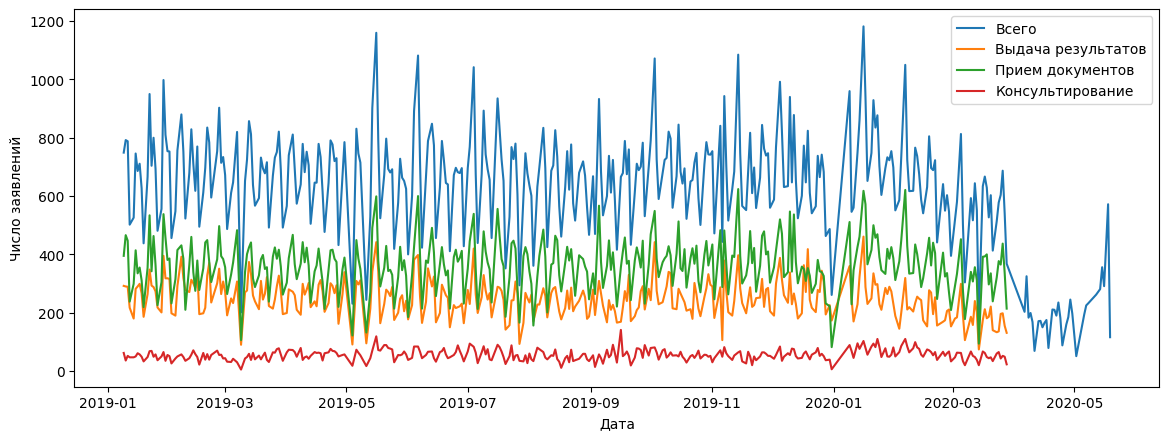

In [ ]:
figure(figsize=(14, 5), dpi=100)
plt.plot(num_of_appl['count'], label='Всего')
plt.plot(count_delivery['N'], label='Выдача результатов')
plt.plot(count_service['N'], label='Прием документов')
plt.plot(count_consultation['N'], label='Консультирование')
plt.ylabel('Число заявлений')
plt.xlabel('Дата')
plt.legend()
None

In [ ]:
time_diff_delivery = get_time_between_appls(delivery)
time_diff_service = get_time_between_appls(service)
time_diff_consultation = get_time_between_appls(consultation)

In [ ]:
example_del = time_diff_delivery[time_diff_delivery['date'] == pd.to_datetime("2019-04-12")] #2019-04-12
example_ser = time_diff_service[time_diff_service['date'] == pd.to_datetime("2019-05-08")]
example_con = time_diff_consultation[time_diff_consultation['date'] == pd.to_datetime("2019-04-12")]

### Исследование закона распределения числа поступающих заявок

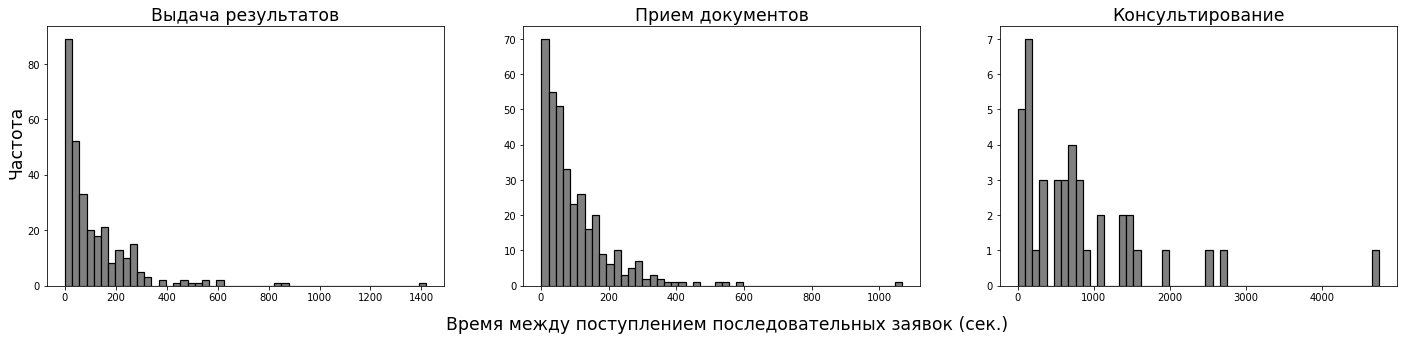

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10,4))

plt.subplots_adjust(wspace=0.2, hspace=0.1, bottom = 0.1, top = 1, right=2)

axs[0].hist(example_del['diff'], bins=50, color='gray', edgecolor='black', linewidth=1.2)
axs[0].set_title('Выдача результатов', fontsize='xx-large')

axs[1].hist(example_ser['diff'], bins=50, color='gray', edgecolor='black', linewidth=1.2)
axs[1].set_title('Прием документов', fontsize='xx-large')

axs[2].hist(example_con['diff'], bins=50, color='gray', edgecolor='black', linewidth=1.2)
axs[2].set_title('Консультирование', fontsize='xx-large')

fig.text(1.07, -0.05, 'Время между поступлением последовательных заявок (сек.)', ha='center', fontsize='xx-large')
fig.text(0.07, 0.6, 'Частота', va='center', rotation='vertical', fontsize='xx-large')

None

In [ ]:
example_del['diff'].describe()

count     301.000000
mean      117.013289
std       149.866896
min         1.000000
25%        26.000000
50%        66.000000
75%       155.000000
max      1417.000000
Name: diff, dtype: float64

In [ ]:
(117/60)**-1

0.5128205128205129

In [ ]:
example_ser['diff'].describe()

count     349.000000
mean       98.934097
std       109.237949
min         1.000000
25%        27.000000
50%        64.000000
75%       133.000000
max      1068.000000
Name: diff, dtype: float64

In [ ]:
(98/60)**-1

0.6122448979591837

In [ ]:
example_con['diff'].describe()

count      41.000000
mean      812.317073
std       909.300732
min         2.000000
25%       183.000000
50%       620.000000
75%      1053.000000
max      4747.000000
Name: diff, dtype: float64

In [ ]:
(812/60)**-1

0.07389162561576355

In [ ]:
ex_del = example_del['diff'][example_del['diff'] < 300] 
stats.anderson(ex_del, 'expon')

AndersonResult(statistic=1.2210000889348862, critical_values=array([0.92 , 1.076, 1.338, 1.603, 1.953]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
stats.anderson(example_ser['diff'], 'expon') 

AndersonResult(statistic=0.29506191355756073, critical_values=array([0.92 , 1.076, 1.339, 1.603, 1.954]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
stats.anderson(example_con['diff'], 'expon') 

AndersonResult(statistic=0.3533888331356181, critical_values=array([0.909, 1.062, 1.322, 1.583, 1.929]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

## Время обслуживания

In [6]:
tickets = pd.read_csv('drive/My Drive/Данные/equeue_ticket.csv', sep=';', index_col=False,
                      encoding = "cp1251", usecols=[0,2,3], error_bad_lines=False)

e_queue_tickets = pd.read_csv('drive/My Drive/Данные/equeue_ticket_order_act.csv',
                              usecols=[0,1,3,4], sep=';', index_col=0)

tickets_full = tickets.merge(right=e_queue_tickets, left_on='id', right_on='equeue_ticket')

del tickets, e_queue_tickets

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
timeser_del = prepare_data_timeser(tickets_full, 'DELIVERY')
timeser_ser = prepare_data_timeser(tickets_full, 'SERVICE')
timeser_con = prepare_data_timeser(tickets_full, 'CONSULTATION')

### Исследование закона распределения времени обслуживания

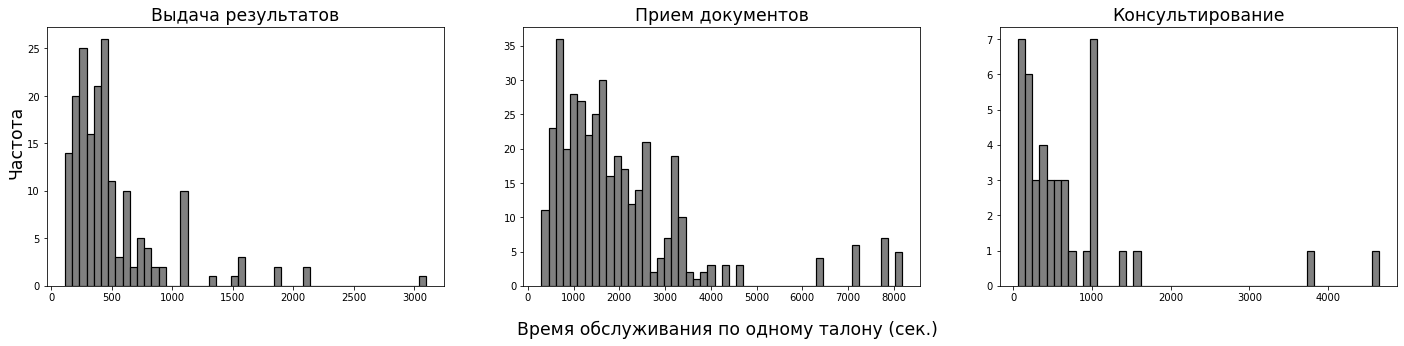

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10,4))

plt.subplots_adjust(wspace=0.2, hspace=0.1, bottom = 0.1, top = 1, right=2)

axs[0].hist(example_time_del['time'], bins=50, color='gray', edgecolor='black', linewidth=1.2)
axs[0].set_title('Выдача результатов', fontsize='xx-large')

axs[1].hist(example_time_ser['time'], bins=50, color='gray', edgecolor='black', linewidth=1.2)
axs[1].set_title('Прием документов', fontsize='xx-large')

axs[2].hist(example_time_con['time'], bins=50, color='gray', edgecolor='black', linewidth=1.2)
axs[2].set_title('Консультирование', fontsize='xx-large')

fig.text(1.07, -0.07, 'Время обслуживания по одному талону (сек.)', ha='center', fontsize='xx-large')
fig.text(0.07, 0.6, 'Частота', va='center', rotation='vertical', fontsize='xx-large')

None

In [ ]:
example_time_del = timeser_del[timeser_del['date'] == pd.to_datetime('2020-03-18')]
example_time_ser = timeser_ser[timeser_ser['date'] == pd.to_datetime('2020-03-18')]
example_time_con = timeser_con[timeser_con['date'] == pd.to_datetime('2019-04-12')]

In [ ]:
example_time_del['time'].describe()

count     302.000000
mean      703.622993
std       550.975938
min        35.097000
25%       322.447750
50%       529.665000
75%       874.634500
max      3354.310000
Name: time, dtype: float64

In [ ]:
(703/60)**-1

0.08534850640113797

In [ ]:
example_time_ser['time'].describe()

count     350.000000
mean     1716.647674
std      1389.487986
min       111.404000
25%       799.117000
50%      1358.979500
75%      2123.377750
max      7974.123000
Name: time, dtype: float64

In [ ]:
(1716/60)**-1

0.03496503496503496

In [ ]:
example_time_con['time'].describe()

count      42.000000
mean      705.365167
std       884.256631
min        58.963000
25%       201.741500
50%       459.298500
75%       974.541250
max      4641.347000
Name: time, dtype: float64

In [ ]:
(705/60)**-1

0.0851063829787234

In [ ]:
ex_del = example_time_del['time'][example_time_del['time'] < 2500] 
stats.anderson(ex_del, 'expon')

AndersonResult(statistic=14.295089876524798, critical_values=array([0.919, 1.074, 1.337, 1.601, 1.95 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
stats.anderson(example_time_del['time'], 'expon') 

AndersonResult(statistic=13.619457509938456, critical_values=array([0.919, 1.074, 1.337, 1.601, 1.951]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
stats.anderson(example_time_ser['time'], 'expon') 

AndersonResult(statistic=22.46127406010845, critical_values=array([0.921, 1.076, 1.339, 1.604, 1.954]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
ex_ser = example_time_ser['time'][example_time_ser['time'] < 7000] 
stats.anderson(ex_ser, 'expon') 

AndersonResult(statistic=18.515906316950577, critical_values=array([0.921, 1.076, 1.339, 1.604, 1.954]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
stats.anderson(example_time_con['time'], 'expon')  # ++

AndersonResult(statistic=0.8272827434481229, critical_values=array([0.909, 1.063, 1.322, 1.583, 1.929]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

# 2 ПРОГНОЗИРОВАНИЕ ЧИСЛА ЗАЯВОК

## Функции

In [ ]:
# функция для разбиения последовательности на обучающие наборы данных
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
def predict(model, data, num_epochs, size_of_window, test_data_size, fut_pred):
  n_features = 1

  X, y = split_sequence(data, size_of_window) #разбиение на последовательность, подаваемую на вход, и на последующее значение
  X = X.reshape((X.shape[0], X.shape[1], n_features))

  # Разбиение на тестовую и тренировочную выборки

  X_train, y_train = X[:-test_data_size], y[:-test_data_size]
  X_test, y_test = X[-test_data_size:], y[-test_data_size:]
  y_test = y_test.reshape(len(X_test), 1)

  del X, y

  # Обучение модели
  model.fit(X_train, y_train, verbose=0, epochs=num_epochs, validation_split=0.1)

  # Расчет метрик качества прогноза
  y_hat = model.predict(X_test)
  dif = y_test - y_hat

  RMSE = mean_squared_error(y_test, y_hat)**0.5
  MAE = mean_absolute_error(y_test, y_hat)
  ME = max_error(y_test, y_hat)
  MPE = sum(dif[dif>0])/len(dif[dif>0])
  MNE = sum(dif[dif<0])/len(dif[dif<0])

  Metrics = dict({'Root Mean Square Error':RMSE,
                  'Mean Absolute Error':MAE,
                  'Max Error':ME, 'Mean Positive Error': MPE,
                  'Mean Negative Error': MNE})
  
  y_hat = [item for sublist in y_hat for item in sublist]
  # прогнозирование на будущий период (вне выборки)
  y_fut_hat = []
  for i in range(fut_pred):
    X = np.array(data[-size_of_window:]).reshape(1, size_of_window, 1)
    y_pred = model.predict(X)[0][0]
    y_fut_hat.append(y_pred)
    data.append(y_pred)

  return y_hat, y_fut_hat, Metrics

## Прогнозирование (Keras)

In [ ]:
count_delivery = count_num_of_appl_per_day(delivery, '2020-03-28')
count_service = count_num_of_appl_per_day(service, '2020-03-28')
count_consultation = count_num_of_appl_per_day(consultation, '2020-03-28')

In [ ]:
list_delivery = list(count_delivery['N']) #348дней
list_service = list(count_service['N'])
list_consultation = list(count_consultation['N'])

In [ ]:
test_data_size = 21
fut_pred = 7

In [ ]:
time = np.arange(datetime(2020,3,29)-timedelta(days=test_data_size),
                datetime(2020,3,29), timedelta(days=1)).astype(datetime)

time2 = np.arange(time[-1], time[-1] + timedelta(days=fut_pred), timedelta(days=1)).astype(datetime)                

### Delivery

In [ ]:
train_window = 9
test_data_size = 21
fut_pred = 7
epochs = 300

In [ ]:
lstm_keras = Sequential()
lstm_keras.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(train_window, 1)))
lstm_keras.add(Dropout(0.1))
lstm_keras.add(LSTM(75, activation='relu'))
lstm_keras.add(Dense(1))
lstm_keras.compile(optimizer='adam', loss='mse')

In [ ]:
preds_del, preds_fut_del, metrics_del = predict(lstm_keras, list_delivery,
                                                epochs, train_window, test_data_size, fut_pred)

In [ ]:
metrics_del

{'Max Error': 63.070953369140625,
 'Mean Absolute Error': 23.23415992373512,
 'Mean Negative Error': -22.934947967529297,
 'Mean Positive Error': 23.633109198676216,
 'Root Mean Square Error': 28.532614214339517}

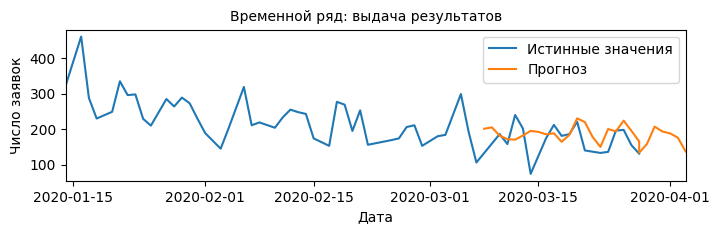

In [ ]:
figure(figsize=(8,2), dpi=100)
plt.xlabel("Дата")
plt.ylabel('Число заявок')
plt.suptitle('Временной ряд: выдача результатов', ha='center', fontsize=10)
plt.autoscale(axis='x', tight=True)
plt.plot(count_delivery['N'][-60:],label='Истинные значения')
plt.plot(list(time)+list(time2),preds_del+preds_fut_del, label='Прогноз')
plt.legend()
plt.show()

### Service

In [ ]:
train_window = 10
test_data_size = 21
fut_pred = 7
epochs = 300

In [ ]:
lstm_keras = Sequential()
lstm_keras.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(train_window, 1)))
lstm_keras.add(Dropout(0.1))
lstm_keras.add(LSTM(75, activation='relu'))
lstm_keras.add(Dense(1))
lstm_keras.compile(optimizer='adam', loss='mse')

In [ ]:
preds_ser, preds_fut_ser, metrics_ser = predict(lstm_keras, list_service, 
                                                epochs, train_window, test_data_size, fut_pred)

In [ ]:
metrics_ser

{'Max Error': 75.33203125,
 'Mean Absolute Error': 22.041983468191965,
 'Mean Negative Error': -12.52203603891226,
 'Mean Positive Error': 37.511898040771484,
 'Root Mean Square Error': 29.720603160713512}

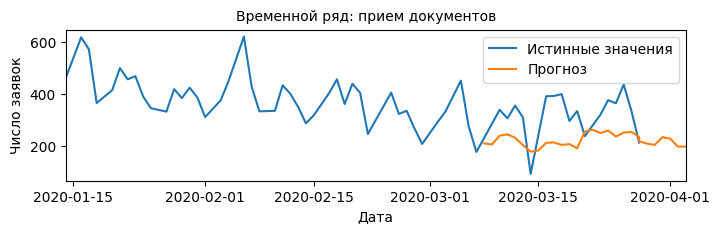

In [ ]:
figure(figsize=(8,2), dpi=100)
plt.xlabel("Дата")
plt.ylabel('Число заявок')
plt.suptitle('Временной ряд: прием документов', ha='center', fontsize=10)
plt.autoscale(axis='x', tight=True)
plt.plot(count_service['N'][-60:],label='Истинные значения')
plt.plot(list(time)+list(time2),preds_ser+preds_fut_ser, label='Прогноз')
plt.legend()
plt.show()

### Consultation

In [ ]:
train_window = 6
test_data_size = 21
fut_pred = 7
epochs = 300

In [ ]:
lstm_keras = Sequential()
lstm_keras.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(train_window, 1)))
lstm_keras.add(Dropout(0.1))
lstm_keras.add(LSTM(75, activation='relu'))
lstm_keras.add(Dense(1))
lstm_keras.compile(optimizer='adam', loss='mse')

In [ ]:
preds_con, preds_fut_con, metrics_con = predict(lstm_keras, list_consultation, 
                                                epochs, train_window, test_data_size, fut_pred)

In [ ]:
metrics_con

{'Max Error': 18.460397720336914,
 'Mean Absolute Error': 9.457443509783063,
 'Mean Negative Error': -10.865301767985025,
 'Mean Positive Error': 8.894300206502278,
 'Root Mean Square Error': 11.14630685106706}

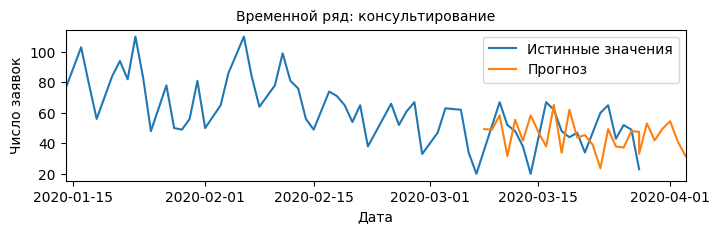

In [ ]:
figure(figsize=(8,2), dpi=100)
plt.xlabel("Дата")
plt.ylabel('Число заявок')
plt.suptitle('Временной ряд: консультирование', ha='center', fontsize=10)
plt.autoscale(axis='x', tight=True)
plt.plot(count_consultation['N'][-60:],label='Истинные значения')
plt.plot(list(time)+list(time2),preds_con+preds_fut_con, label='Прогноз')
plt.legend()
plt.show()

# 3 МОДЕЛИРОВАНИЕ СМО

## Расчет интенсивностей

In [ ]:
mu_del = (timeser_del[(timeser_del['date'] > '2020-01-01') &
                      (timeser_del['date'] <= '2020-03-28')]['time'].mean() / 60)**-1
mu_ser = (timeser_ser[(timeser_ser['date'] > '2020-01-01') &
                      (timeser_ser['date'] <= '2020-03-28')]['time'].mean() / 60)**-1
mu_con = (timeser_con[(timeser_con['date'] > '2020-01-01') &
                      (timeser_con['date'] <= '2020-03-28')]['time'].mean() / 60)**-1

In [ ]:
mu_del, mu_ser, mu_con

(0.08319770434037224, 0.030534557457716886, 0.09902187249660611)

In [ ]:
preds_fut_del[0], preds_fut_ser[0], preds_fut_con[0]

(181.58391, 349.14536, 49.591095)

In [ ]:
lam_del = (8*60/(preds_fut_del[0] + 23)) **-1
lam_ser = (8*60/(preds_fut_ser[0] + 24)) **-1
lam_con = (8*60/(preds_fut_con[0] + 9)) **-1

In [ ]:
lam_del, lam_ser, lam_con

(0.42621647516886396, 0.7773861567179362, 0.12206478118896485)

## Класс СМО

In [11]:
class QueuingSystem(object):
    def __init__(self, N, M, LAM, MU, NU): 
        self.n = N # Число окон обслуживания
        self.m = M # Число мест в очереди
        self.lam = LAM # Интенсивность входного потока
        self.nu = NU # Интенсивность обслуживания
        self.mu = MU # Инстенсивность ухода заявок из очереди
        self.rho = self.lam / self.mu
        self.beta = self.nu / self.mu
          
    
    #Матрица плотностей перехода из состояния в состояние
    def FindL(self, n, m, lam, mu, nu): 
        L = np.zeros((n+m+1, n+m+1)) 
        for i in range(n+1):
            L[i][i+1] = lam
            L[i][i-1] = i*mu

        for i in range(m):
            L[n+i][n+i+1] = lam
            L[n+i][n+i-1] = n*mu + i*nu

        for i in range(1, m+n):
            L[i][i] = -(L[i][i+1] + L[i][i-1])

        L[0][0] = -lam
        L[n+m][n+m-1] = n*mu + m*nu
        L[n+m][n+m] = -L[n+m][n+m-1]
        return L
   

    #Стационарное распределение вероятности
    def FindProbabilities(self, n, m, lam, mu, nu):
        P = np.zeros((n+m+1, 1))

        for i in range(n+1): 
            P[0] += pow(lam/mu, i)/math.factorial(i)
        mul = 0
        mul_k = 1
        for j in range(1, m+1):
            for k in range(1, j+1):
                mul_k *= (lam/(n*mu + k*nu))
            mul += mul_k
            mul_k = 1

        P[0] += pow(lam/mu, n)/math.factorial(n)*mul   
        P[0] = pow(P[0], -1)

        for i in range(1,n+1):
            P[i] = P[0]*pow(lam/mu, i)/math.factorial(i) 
        mul_k = 1
        k = 0
        for i in range(n+1, n+m+1):
            k = k+1
            for k in range(1, k+1):
                mul_k *= (lam/(n*mu + k*nu))
            P[i] = P[n]*mul_k
            mul_k = 1

        return(P)
    
    
    # Среднее число занятых каналов (z)
    def AverageNumberOfBusyChannels(self, n, P):
        avernum = 0
        for i in range(1,n):
            avernum += i*P[i]
        avernum += n*(1-sum(P[0:n]))
        return float(avernum)
    
    
    # Среднее число зявок в очереди (r)
    def AverageNumberOfApplicationsInQueue(self, n, P, rho, beta): 
        return float(rho/beta - self.AverageNumberOfBusyChannels(n, P)/beta)
    
    
    # Абсолютная пропускная способность
    def AbsoluteThroughput(self, lam, nu, n, P, rho, beta):
        return lam - nu*self.AverageNumberOfApplicationsInQueue(n, P, rho, beta)
    
    
    # Относительная пропускная способность
    def RelativeThroughput(self, lam, nu, n, P, rho, beta):
        return self.AbsoluteThroughput(lam, nu, n, P, rho, beta)/lam
    
    
    # Среднее время пребывания в очереди
    def AverageTimeSpendingInQueue(self, n, P, rho, beta, lam):
        return self.AverageNumberOfApplicationsInQueue(n, P, rho, beta)/lam
    
    
    # Среднее время обслуживания
    def AverageServiceTime(self, lam, mu, nu, n, P, rho, beta):
        return self.RelativeThroughput(lam, nu, n, P, rho, beta)/mu

    
    # РАСЧЕТ ХАРАКТЕРИСТИК СИСТЕМЫ
    def FindCharacteristics(self):
        self.L = self.FindL(self.n, self.m, self.lam, self.mu, self.nu) 
        self.P = self.FindProbabilities(self.n, self.m, self.lam, self.mu, self.nu) 
        
        self.P0 = float(self.P[0])
        self.P_otk = float(self.P[-1])
        
        self.N_busy = self.AverageNumberOfBusyChannels(self.n, self.P)
        self.N_pr = self.n - self.N_busy
        self.k_busy = self.N_busy / self.n
        self.k_pr = 1 - self.k_busy
        
        self.q = self.RelativeThroughput(self.lam, self.nu, self.n, self.P, self.rho, self.beta)
        self.A = 60*self.AbsoluteThroughput(self.lam, self.nu, self.n, self.P, self.rho, self.beta)
        
        self.L_queue = self.AverageNumberOfApplicationsInQueue(self.n, self.P, self.rho, self.beta)
        self.L_total = self.L_queue + self.N_busy 
        
        self.t_queue = self.AverageTimeSpendingInQueue(self.n, self.P, self.rho, self.beta, self.lam)
        self.t_serv = self.AverageServiceTime(self.lam, self.mu, self.nu, self.n, self.P, self.rho, self.beta)
        self.t_total = self.t_queue + self.t_serv

## Стационарный режим 

In [8]:
# константы
m = 30 # ограниченность очереди
nu = 1/45 #мин^-1
n = 30 #всего окон обслуживания

In [9]:
# интенсивности входного потока
lam_del, lam_ser, lam_con = 0.42621647516886396, 0.7773861567179362, 0.12206478118896485

# интенсивности обслуживания
mu_del, mu_ser, mu_con = 0.08319770434037224, 0.030534557457716886, 0.09902187249660611

In [13]:
def StationaryPhase(system, type, legend_ncol=7, bbox_to_anchor=(1.9, 0.8)):
  w, v = LA.eig(system.L.T) # собственные числа и собственные векторы
  # print('Собственные числа матрицы Lam.T:')
  # print(w)

  b = np.zeros_like(v[0])
  b[0] = 1
  C = LA.solve(v, b)

  t = np.linspace(0, 90, 1000) # временной промежуток

  # динамическое создание переменных
  probas = []
  for i in range(system.n+system.m+1):
    probas.append("p" + str(i))

  values = [0 for i in range(system.n+system.m+1)]

  i = 0
  for x,y in zip(probas, values):
    globals()[x] = y
    for j in range(system.n+system.m+1):
      globals()[x] += C[j]*v[:,j][i]*np.exp(w[j]*t)
    i += 1

  i = 0
  fig, ax = plt.subplots(figsize=(8,4)) 
  fig.suptitle(type, fontsize=14)
  for x,y in zip(probas, values):                      
    ax.plot(t, globals()[x], label="P" + str(i) + "(t)")  
    i += 1       
  ax.set_xlabel("Время (мин.)")                             
  ax.set_ylabel("Вероятность")                             
  ax.legend(ncol=legend_ncol, bbox_to_anchor=bbox_to_anchor)                                    
  plt.show()  

In [50]:
system_delivery = QueuingSystem(9, m, lam_del, mu_del, nu)
system_delivery.FindCharacteristics()

system_service = QueuingSystem(18, m, lam_ser, mu_ser, nu)
system_service.FindCharacteristics()

system_consultation = QueuingSystem(3, m, lam_con, mu_con, nu)
system_consultation.FindCharacteristics()

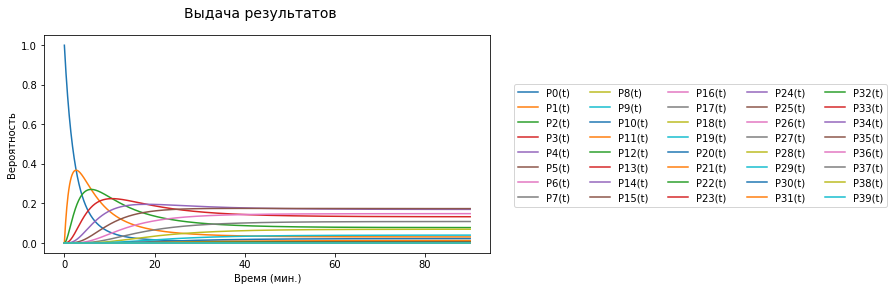

In [51]:
StationaryPhase(system_delivery, 'Выдача результатов', 5)

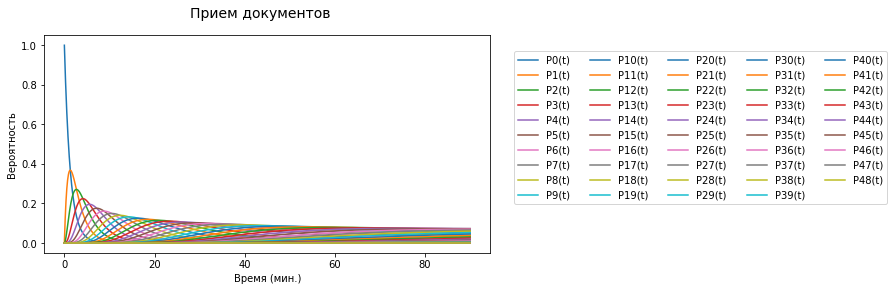

In [52]:
StationaryPhase(system_service, 'Прием документов', 5, (1.9, 0.95))

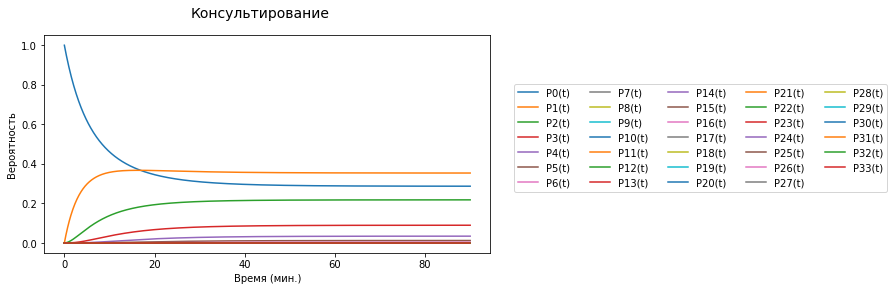

In [53]:
StationaryPhase(system_consultation, 'Консультирование', 5)

In [54]:
system_delivery.__dict__

{'A': 25.44837512137129,
 'L': array([[-0.42621648,  0.42621648,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.0831977 , -0.50941418,  0.42621648, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.16639541, -0.59261188, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -1.79721804,
          0.42621648,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  1.39322378,
         -1.81944026,  0.42621648],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          1.41544601, -1.41544601]]),
 'L_queue': 0.09346004157041321,
 'L_total': 5.191432259902062,
 'N_busy': 5.097972218331649,
 'N_pr': 3.902027781668351,
 'P': array([[5.90114492e-03],
        [3.02311849e-02],
        [7.74362056e-02],
        [1.32233563e-01],
        [1.69356004e-01],
        [1.73519978e-01],
        [1.48155277e-01],
        [1.08427133e-01],
        

In [47]:
system_service.__dict__

{'A': 39.29492687442786,
 'L': array([[-0.77738616,  0.77738616,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.03053456, -0.80792071,  0.77738616, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.06106911, -0.83845527, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -2.07136864,
          0.77738616,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  1.31620471,
         -2.09359087,  0.77738616],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          1.33842693, -1.33842693]]),
 'L_queue': 5.511181896486235,
 'L_total': 26.959517894610112,
 'N_busy': 21.448335998123877,
 'N_pr': 0.551664001876123,
 'P': array([[6.95390683e-12],
        [1.77041076e-10],
        [2.25366426e-09],
        [1.91255148e-08],
        [1.21730195e-07],
        [6.19831273e-07],
        [2.63007060e-06],
        [9.56565116e-06],
        

In [55]:
system_consultation.__dict__

{'A': 7.218431684085994,
 'L': array([[-0.12206478,  0.12206478,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.09902187, -0.22108665,  0.12206478, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.19804374, -0.32010853, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -1.04135262,
          0.12206478,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.94151006,
         -1.06357484,  0.12206478],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.96373228, -0.96373228]]),
 'L_queue': 0.07909139043892299,
 'L_total': 1.294047154266657,
 'N_busy': 1.214955763827734,
 'N_pr': 1.785044236172266,
 'P': array([[2.86745269e-01],
        [3.53472396e-01],
        [2.17863637e-01],
        [8.95205492e-02],
        [3.42239976e-02],
        [1.22325672e-02],
        [4.10512265e-03],
        [1.29831597e-03],
        

## Определение оптимального распределения окон

In [22]:
def FindOptimalNumberOfServiceWindows(n, m, lam_d, lam_s, lam_c, mu_d, mu_s, mu_c, nu, q_opt_d, q_opt_s, q_opt_c):
  n_c_init = 2
  n_d_init = 2
  L_TOTAL_MAX = 1000

  for n_s in range(5, (n - n_c_init - n_d_init + 1)):
    for n_c in range (n_c_init, n - n_d_init - n_s +1):
      n_d = n - n_s - n_c
      system_delivery = QueuingSystem(n_d, m, lam_d, mu_d, nu)
      system_delivery.FindCharacteristics()

      system_service = QueuingSystem(n_s, m, lam_s, mu_s, nu)
      system_service.FindCharacteristics()

      system_consultation = QueuingSystem(n_c, m, lam_c, mu_c, nu)
      system_consultation.FindCharacteristics()
      
      L_TOTAL = system_delivery.L_total + system_service.L_total + system_consultation.L_total
      if ((L_TOTAL < L_TOTAL_MAX) 
          # and (system_delivery.q > q_opt_d) 
          # and (system_service.q > q_opt_s) 
          # and (system_consultation.q > q_opt_c)):
      ):
            L_TOTAL_MAX = L_TOTAL
            n_d_opt = n_d
            n_s_opt = n_s
            n_c_opt = n_c
  if (L_TOTAL_MAX == 1000):
    print("Оптимального распределения окон обслуживания, удовлетворяющим заданным условиям, обнаружить не удалось. Попробуйте изменить условия.")  
    return 0,0,0
  else:
    return n_d_opt, n_s_opt, n_c_opt

**Число окон: 30**

In [56]:
# константы
m = 30 # ограниченность очереди
nu = 1/45 #мин^-1
n = 30 #всего окон обслуживания

In [57]:
# интенсивности входного потока
lam_del, lam_ser, lam_con = 0.42621647516886396, 0.7773861567179362, 0.12206478118896485

# интенсивности обслуживания
mu_del, mu_ser, mu_con = 0.08319770434037224, 0.030534557457716886, 0.09902187249660611

In [58]:
n_del, n_ser, n_con = FindOptimalNumberOfServiceWindows(n, m, lam_del, lam_ser, lam_con, mu_del, mu_ser, mu_con, nu,
                                                        0.85, 0.8, 0.85)

In [59]:
n_del, n_ser, n_con 

(7, 21, 2)

In [60]:
system_delivery = QueuingSystem(n_del, m, lam_del, mu_del, nu)
system_delivery.FindCharacteristics()

system_service = QueuingSystem(n_ser, m, lam_ser, mu_ser, nu)
system_service.FindCharacteristics()

system_consultation = QueuingSystem(n_con, m, lam_con, mu_con, nu)
system_consultation.FindCharacteristics()

In [61]:
system_delivery.q, system_service.q, system_consultation.q

(0.9722197571943563, 0.8110334120898988, 0.930566740615482)

In [62]:
system_delivery.__dict__

{'A': 24.86256468005444,
 'L': array([[-0.42621648,  0.42621648,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.0831977 , -0.50941418,  0.42621648, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.16639541, -0.59261188, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -1.63082263,
          0.42621648,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  1.22682837,
         -1.65304485,  0.42621648],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          1.2490506 , -1.2490506 ]]),
 'L_queue': 0.5328178725580486,
 'L_total': 5.513437004855772,
 'N_busy': 4.980619132297724,
 'N_pr': 2.019380867702276,
 'P': array([[5.56314165e-03],
        [2.84996160e-02],
        [7.30008476e-02],
        [1.24659545e-01],
        [1.59655703e-01],
        [1.63581175e-01],
        [1.39669302e-01],
        [1.02216690e-01],
        [

In [63]:
system_service.__dict__

{'A': 37.829168831664035,
 'L': array([[-0.77738616,  0.77738616,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.03053456, -0.80792071,  0.77738616, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.06106911, -0.83845527, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -2.04083409,
          0.77738616,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  1.28567015,
         -2.06305631,  0.77738616],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          1.30789237, -1.30789237]]),
 'L_queue': 6.6105004285591065,
 'L_total': 27.25878223409941,
 'N_busy': 20.648281805540304,
 'N_pr': 0.3517181944596963,
 'P': array([[6.48190566e-12],
        [1.65024292e-10],
        [2.10069526e-09],
        [1.78273575e-08],
        [1.13467675e-07],
        [5.77759803e-07],
        [2.45155276e-06],
        [8.91637607e-06],
      

In [64]:
system_consultation.__dict__

{'A': 6.815365534497421,
 'L': array([[-0.12206478,  0.12206478,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.09902187, -0.22108665,  0.12206478, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.19804374, -0.32010853, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -0.94233075,
          0.12206478,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.84248819,
         -0.96455297,  0.12206478],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.86471041, -0.86471041]]),
 'L_queue': 0.38139100263035264,
 'L_total': 1.5285055007817605,
 'N_busy': 1.1471144981514079,
 'N_pr': 0.8528855018485921,
 'P': array([[2.63830272e-01],
        [3.25224959e-01],
        [2.00453255e-01],
        [1.11085172e-01],
        [5.59185468e-02],
        [2.57854806e-02],
        [1.09694704e-02],
        [4.33111750e-03],
     